<a href="https://colab.research.google.com/github/yucellgereklioglu/datasciencework/blob/main/predict_calories_ycl_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier,LGBMRegressor
from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,r2_score
train=pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')
##submission=pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')


In [ ]:
train=train.drop(columns=['id'])
le=LabelEncoder()
train['Sex']=le.fit_transform(train['Sex'])
test['Sex']=le.fit_transform(test['Sex'])

In [ ]:
y = train['Calories']
X=train.drop(['Calories'],axis=1)
X = X.copy()
y_log = np.log1p(y)
numeric_cols = X.select_dtypes(include=[np.number]).columns
positive_cols = [col for col in numeric_cols if (X[col] > 0).all()]
X[positive_cols] = X[positive_cols].apply(np.log1p)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train_log, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=42)


In [ ]:
X = X.copy()
y_log = np.log1p(y)
numeric_cols = X.select_dtypes(include=[np.number]).columns
positive_cols = [col for col in numeric_cols if (X[col] > 0).all()]
X[positive_cols] = X[positive_cols].apply(np.log1p)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [ ]:
train.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
Sex,750000.000000,0.499039,0.499999,0.000000,0.000000,0.000000,1.000000,1.000000
Age,750000.000000,41.420404,15.175049,20.000000,28.000000,40.000000,52.000000,79.000000
Height,750000.000000,174.697685,12.824496,126.000000,164.000000,174.000000,185.000000,222.000000
Weight,750000.000000,75.145668,13.982704,36.000000,63.000000,74.000000,87.000000,132.000000
Duration,750000.000000,15.421015,8.354095,1.000000,8.000000,15.000000,23.000000,30.000000
Heart_Rate,750000.000000,95.483995,9.449845,67.000000,88.000000,95.000000,103.000000,128.000000
Body_Temp,750000.000000,40.036253,0.779875,37.100000,39.600000,40.300000,40.700000,41.500000
Calories,750000.000000,88.282781,62.395349,1.000000,34.000000,77.000000,136.000000,314.000000


In [ ]:
test.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
id,250000.000000,874999.500000,72168.927986,750000.000000,812499.750000,874999.500000,937499.250000,999999.000000
Sex,250000.000000,0.498876,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000
Age,250000.000000,41.452464,15.177769,20.000000,28.000000,40.000000,52.000000,79.000000
Height,250000.000000,174.725624,12.822039,127.000000,164.000000,174.000000,185.000000,219.000000
Weight,250000.000000,75.147712,13.979513,39.000000,63.000000,74.000000,87.000000,126.000000
Duration,250000.000000,15.415428,8.349133,1.000000,8.000000,15.000000,23.000000,30.000000
Heart_Rate,250000.000000,95.479084,9.450161,67.000000,88.000000,95.000000,103.000000,128.000000
Body_Temp,250000.000000,40.036093,0.778448,37.100000,39.600000,40.300000,40.600000,41.500000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


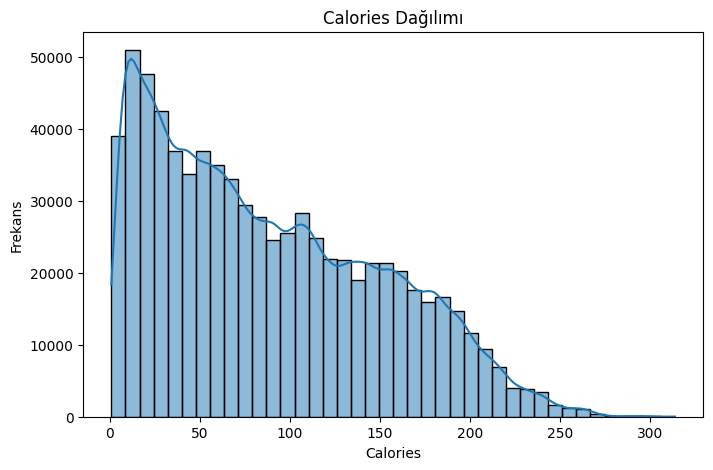

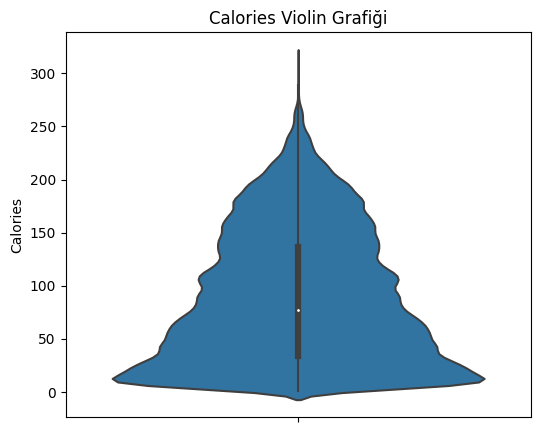

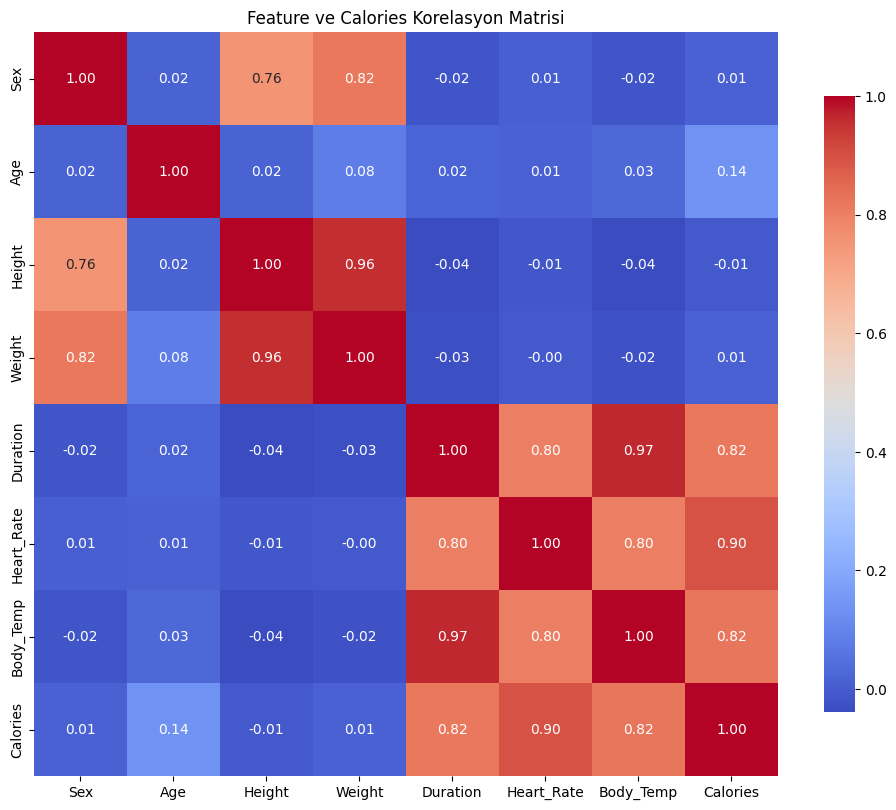

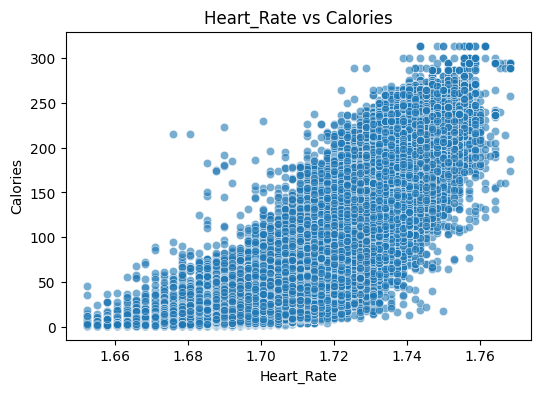

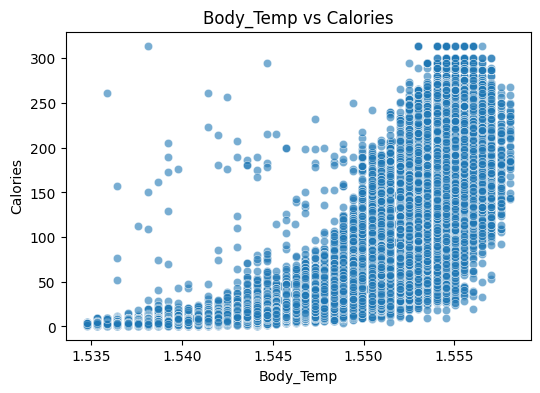

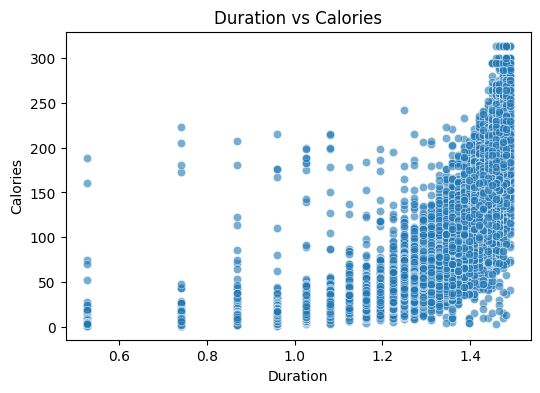

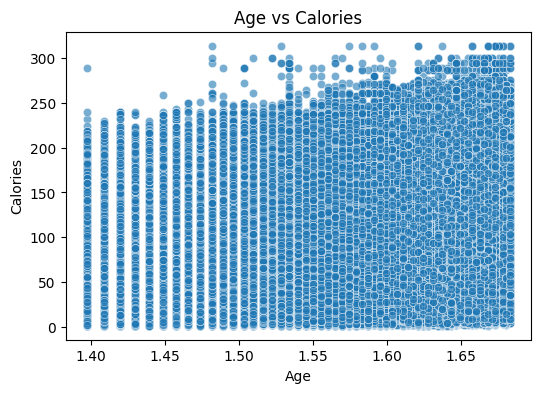

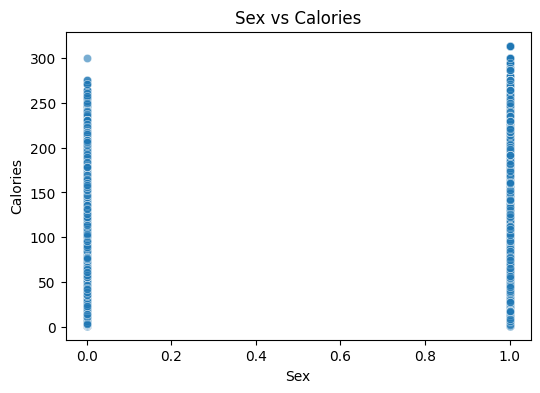

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# y ve X zaten tanımlı:
# y = train['Calories']
# X = train.drop(['Calories'], axis=1).copy()

# 1. Calories histogram ve dağılımı
plt.figure(figsize=(8,5))
sns.histplot(y, bins=40, kde=True)
plt.title('Calories Dağılımı')
plt.xlabel('Calories')
plt.ylabel('Frekans')
plt.show()

# 2. Calories violin plot (distribution yoğunluk)
plt.figure(figsize=(6,5))
sns.violinplot(y=y)
plt.title('Calories Violin Grafiği')
plt.show()

# 3. Korelasyon matrisi (X ve Calories dahil)
df_corr = X.copy()
df_corr['Calories'] = y
corr_matrix = df_corr.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title('Feature ve Calories Korelasyon Matrisi')
plt.show()

# 4. Sayısal feature'lar ile Calories arasındaki saçılım (scatter) grafikleri
# Özellikle yüksek korelasyonlu değişkenlerle yapabiliriz
high_corr_features = corr_matrix['Calories'].abs().sort_values(ascending=False)
top_features = high_corr_features[1:6].index.tolist()  # ilk 5 korelasyonlu feature (Calories hariç)

for feature in top_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X[feature], y=y, alpha=0.6)
    plt.title(f'{feature} vs Calories')
    plt.xlabel(feature)
    plt.ylabel('Calories')
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error


In [ ]:
from catboost import CatBoostRegressor, Pool, cv
train_pool = Pool(X_train, y_train_log)
params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'early_stopping_rounds': 50,
    'verbose': 100,
    'task_type': 'CPU'
}
cv_data = cv(
    params=params,
    pool=train_pool,
    fold_count=4,
    shuffle=True,
    partition_random_seed=42,
    stratified=False,
    verbose=100,
    early_stopping_rounds=50
)

best_iter = np.argmin(cv_data['test-RMSE-mean']) + 1
print(f"En iyi iterasyon sayısı (CV ile): {best_iter}")
final_model = CatBoostRegressor(
    iterations=best_iter,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)
final_model.fit(
    X_train, y_train_log,
    eval_set=(X_test, y_test_log),
    use_best_model=True,
    verbose=100
)


Training on fold [0/4]
0:	learn: 4.0402355	test: 4.0421313	best: 4.0421313 (0)	total: 107ms	remaining: 1m 46s
100:	learn: 0.0869432	test: 0.0868379	best: 0.0868379 (100)	total: 4.34s	remaining: 38.6s
200:	learn: 0.0673916	test: 0.0676812	best: 0.0676812 (200)	total: 8.27s	remaining: 32.9s
300:	learn: 0.0624493	test: 0.0629614	best: 0.0629614 (300)	total: 12s	remaining: 27.9s
400:	learn: 0.0605865	test: 0.0613432	best: 0.0613432 (400)	total: 15.6s	remaining: 23.3s
500:	learn: 0.0596416	test: 0.0606162	best: 0.0606158 (499)	total: 19.2s	remaining: 19.1s
600:	learn: 0.0590647	test: 0.0602692	best: 0.0602692 (600)	total: 23.1s	remaining: 15.3s
700:	learn: 0.0586343	test: 0.0600391	best: 0.0600391 (700)	total: 26.8s	remaining: 11.4s
800:	learn: 0.0583045	test: 0.0598844	best: 0.0598844 (800)	total: 30.4s	remaining: 7.56s
900:	learn: 0.0580568	test: 0.0597827	best: 0.0597827 (900)	total: 34s	remaining: 3.74s
999:	learn: 0.0578557	test: 0.0597040	best: 0.0597040 (999)	total: 38.2s	remaining: 

In [ ]:
y_pred_log = final_model.predict(X_test)

y_test_orig = np.expm1(y_test_log)
y_pred_orig = np.expm1(y_pred_log)

rmsle = np.sqrt(np.mean((np.log1p(y_pred_orig) - np.log1p(y_test_orig))**2))
rmsle

0.05945312363626733

In [ ]:
pred=final_model.predict(test)

In [ ]:
submission=pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')

In [ ]:
submission['Calories'] = np.clip((pred) / 2, 1, 314)
submission['Calories'] *= 76.46 / submission['Calories'].mean()


In [ ]:
submission.to_csv('submission.csv', index=False)
